In [1]:
import sys
sys.path.append("../")
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler, AutoencoderKL
from PIL import Image

model_id = "stabilityai/stable-diffusion-2-1-base"
with torch.no_grad():
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    vae = AutoencoderKL.from_pretrained(model_id, subfolder = "vae", revision = None).to("cuda")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/chenhong/.conda/envs/diffusion/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [58]:
from torchvision import transforms
def my_generation(ref_img, prior, pipe, vae, prompt, img_resolution, num_inference_steps, guidance, latents=None, generator=None, prompt_embeds = None, num_images_per_prompt = 1):
    with torch.no_grad():
        image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
        device = pipe._execution_device
        do_classifier_free_guidance = guidance_scale > 1.0
        prompt_embeds = pipe._encode_prompt(prompt,device,num_images_per_prompt,
                do_classifier_free_guidance,
                negative_prompt = None,
                prompt_embeds = None,
                negative_prompt_embeds = None)

        pipe.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = pipe.scheduler.timesteps
        num_channels_latents = pipe.unet.in_channels
        height = img_resolution
        width = img_resolution
        latents = pipe.prepare_latents(
                    batch_size * num_images_per_prompt,
                    num_channels_latents,
                    height,
                    width,
                    prompt_embeds.dtype,
                    device,
                    generator,
                    latents,
                )
        img_feature = vae.encode( image_transform(init_image).cuda().view(1, 3, 512, 512) ).latent_dist.sample().to(prompt_embeds.dtype)
        latents = latents #+ prior*img_feature
        num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
        with pipe.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds,cross_attention_kwargs=None).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                    progress_bar.update()
            image = pipe.decode_latents(latents)
            image, has_nsfw_concept = pipe.run_safety_checker(image, device, prompt_embeds.dtype)
            image = pipe.numpy_to_pil(image)
    return image

In [63]:
prompt = "in the forest"
guidance_scale = 7.0
img_resolution = 512
num_inference = 50
prior = 0.0
init_img = Image.open("./training_data/images/dog1.jpg").convert("RGB").resize((img_resolution, img_resolution))

image = my_generation(init_img, prior, pipe, vae, prompt, img_resolution, num_inference, guidance_scale)

  0%|          | 0/50 [00:00<?, ?it/s]

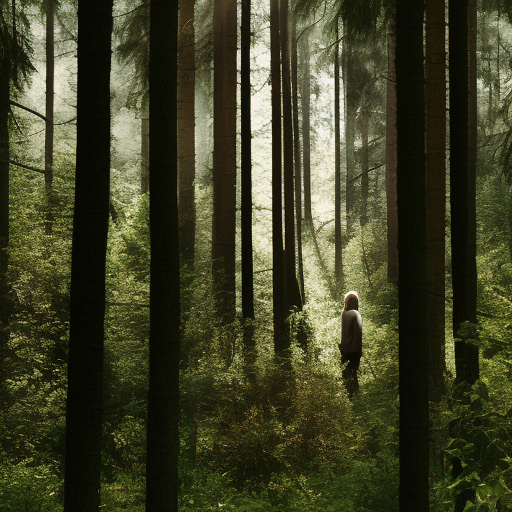

In [64]:
image[0]